In [1]:
!pip install scikit_learn

In [2]:
# Imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
from tqdm import tqdm
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchviz import make_dot, make_dot_from_trace
from torch.utils.data import DataLoader, Dataset
import os
import torch.nn.functional as F
from torchsummary import summary
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import time
import pathlib
from torch.optim import Adam
from torch.autograd import Variable
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import sklearn

In [3]:
data_dir = pathlib.Path('./real_data')
print(data_dir)

real_data


In [4]:
os.chdir(data_dir)
class_names = [name for name in os.listdir(".") if os.path.isdir(name)]
class_names.remove('.ipynb_checkpoints')
class_names.remove('bike') #bmp file can not use
class_names.remove('cars') #bmp file can not feed into the model
print(class_names)
os.chdir('../')
cwd = os.getcwd()
print("Current working directory: {0}".format(cwd))
#label encoder
le = preprocessing.LabelEncoder()
le.fit(class_names)
label_list = le.transform(class_names)
class_list = le.inverse_transform(label_list)
print(label_list)
print(class_list)
num_class = len(class_names)

image_files = [[os.path.join(data_dir, class_name, x) for x in os.listdir(os.path.join(data_dir, class_name))] for class_name in class_names]

['dogs', 'horses', 'cats', 'flowers', 'human']
Current working directory: /demo
[1 3 0 2 4]
['dogs' 'horses' 'cats' 'flowers' 'human']


In [5]:
# the way to get label
z = le.transform(['dogs'])[0]
print(z)

1


In [6]:
images_paths = []
for i in range(num_class):
    for j in range(len(image_files[i])):
        current = image_files[i]
        images_paths.append(current[j])
print(f"Number of image {len(images_paths)}")

Number of image 1018


In [7]:
training_transforms = transforms.Compose([transforms.Resize(256),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

In [8]:
train_and_valid_data,test_data_path = train_test_split(images_paths,shuffle = True)
train_data_path, valid_data_path = train_test_split(train_and_valid_data, shuffle = True, test_size = 0.2)
print(len(train_data_path))
print(len(valid_data_path))
print(len(test_data_path))

610
153
255


In [9]:
train_data_path[0]

'real_data/dogs/dog.60.jpg'

In [10]:
from torch.utils.data import Dataset
from random import randint
from PIL import Image
class ImageDataset(Dataset):
    def __init__(self, label_encoder, base_dir, transform=None):
        super().__init__()
    
        self.base_dir = base_dir
        self.label_encoder = label_encoder
        self.transform = transform
        
    def __len__(self):
        return len(self.base_dir)
    
    def __getitem__(self, index):
        
        image_path = self.base_dir[index]
        
        image = Image.open(image_path).convert('RGB') ## 因為可能dataset有4維，所以要轉成RGB
        
        #get label
        label_name = image_path.split('/')[-2]
        
        #label encoding 
        label = self.label_encoder.transform([label_name])[0]
        
        if self.transform is not None:
            image = self.transform(image)
        return (image, label)

In [11]:
train_data = ImageDataset(le, train_data_path, training_transforms)
test_data = ImageDataset(le, test_data_path, testing_transforms)
valid_data = ImageDataset(le, valid_data_path, validation_transforms)

In [12]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size = 8, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = 8, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 8, shuffle = True)
#len of dataloader is number of batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 224, 224])


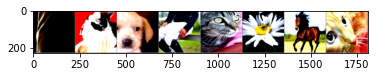

4 0 1 4 0 2 3 0


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(8)))

In [14]:
# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
    outputs = model(images)
    
    _, predicted = torch.max(outputs, 1)
    
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

In [15]:
# Function to save the model
def saveModel():
    path = "./ResNet18+intel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0
    valid_loss = 0.0
    loss_fn = nn.CrossEntropyLoss()
    number = 0
    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            valid_loss += loss_fn(outputs, labels).item()
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            number += 1
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    loss = valid_loss / number
    return(accuracy,loss)

In [16]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

In [17]:
model = ResNet_18(3, 6)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
# Convert model parameters and buffers to CPU or Cuda
model.to(device)

The model will be running on cuda:0 device


ResNet_18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=

In [18]:
def inference_test():
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    print(f"testing accuracy : {accuracy}%")


In [19]:
if __name__ == "__main__":
    start = time.time()
    num_epochs = 50
    best_accuracy = 0.0
    accuracy_history = []
    loss_history = []
    valid_history = []
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            #將梯度初始化为零
            optimizer.zero_grad()
            # 向前傳播求出預測的值
            outputs = model(images)
            # 用output和label計算loss
            loss = loss_fn(outputs, labels)
            # 反向傳播
            loss.backward()
            # 更新參數
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 100 == 99:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy, valid_loss = testAccuracy()
        valid_history.append(accuracy)
        loss_history.append(valid_loss)
        print(f"For epoch', epoch+1,'the test accuracy  is {int(accuracy)}% and loss is {valid_loss}")
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            path = "./ResNet18+intel1.pth"
            torch.save(model.state_dict(), path)
            best_accuracy = accuracy
        end = time.time()
        print(f"time : {end-start}")
        
    inference_test()

For epoch', epoch+1,'the test accuracy  is 35% and loss is 2.15848610996959
time : 4.193403482437134
For epoch', epoch+1,'the test accuracy  is 26% and loss is 1.6436853051185607
time : 7.706519603729248
For epoch', epoch+1,'the test accuracy  is 33% and loss is 1.566373199224472
time : 11.230193853378296
For epoch', epoch+1,'the test accuracy  is 35% and loss is 1.4270643174648285
time : 14.785640239715576
For epoch', epoch+1,'the test accuracy  is 33% and loss is 1.4013065367937088
time : 18.314592599868774
For epoch', epoch+1,'the test accuracy  is 38% and loss is 1.368518328666687
time : 22.055001735687256
For epoch', epoch+1,'the test accuracy  is 39% and loss is 1.2728333711624145
time : 25.632452964782715
For epoch', epoch+1,'the test accuracy  is 40% and loss is 1.3991253137588502
time : 29.19782519340515
For epoch', epoch+1,'the test accuracy  is 47% and loss is 1.288461023569107
time : 32.76025342941284
For epoch', epoch+1,'the test accuracy  is 41% and loss is 1.282190087437

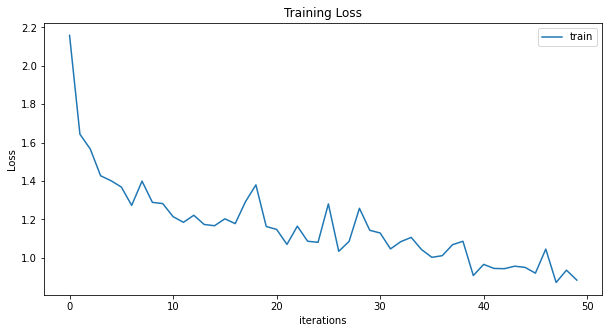

In [20]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(loss_history,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

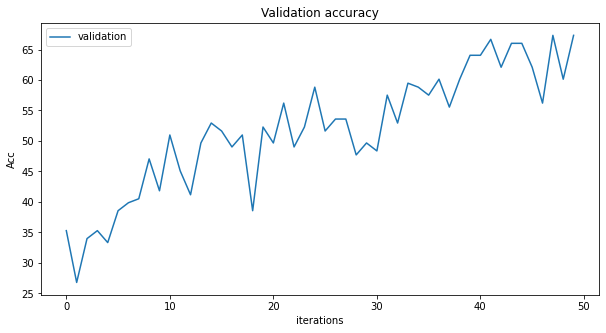

In [21]:
plt.figure(figsize=(10,5))
plt.title("Validation accuracy")
plt.plot(valid_history,label="validation")
plt.xlabel("iterations")
plt.ylabel("Acc")
plt.legend()

f1 score is 0.6963038322180842


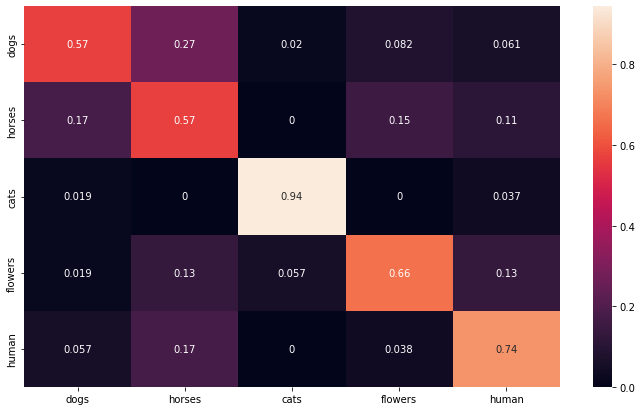

In [22]:
def draw_confusion_matrix():

    y_pred = []
    y_true = []

    # iterate over test data
    for data in test_loader:
        images, labels = data
        images = Variable(images.to(device))

        output = model(images) # Feed Network
        _, predicted = torch.max(output.data, 1)
        predicted = predicted.data.cpu().numpy()
        y_pred.extend(predicted) # Save Prediction

        y_true.extend(labels) # Save Truth

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in class_list],
                         columns = [i for i in class_list])
    plt.figure(figsize = (12,7))
    sb.heatmap(df_cm, annot=True)
    score = f1_score(y_true,y_pred,average='macro')
    print(f"f1 score is {score}")
    #plt.savefig('output.png')

draw_confusion_matrix()